In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# making training data_Box car shape
x_train = np.linspace(0,1,10).reshape(-1,1)
arg_idx = np.argwhere((x_train < 0.4) | (x_train >0.6)).ravel()
#y_train = np.where(0.4<x_train<0.6,1,).reshape(-1,1)
y_train = np.ones_like(x_train)
y_train[arg_idx] = 0

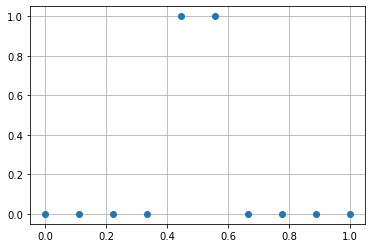

In [45]:
plt.plot(x_train,y_train,'o')
plt.grid()

In [46]:
x_test = np.linspace(0,1,10000).reshape(-1,1)
arg_idx = np.argwhere((x_test < 0.4) | (x_test >0.6)).ravel()
#y_test = np.where(x_test<0.5,0,1).reshape(-1,1)
y_test = np.ones_like(x_test)
y_test[arg_idx] = 0

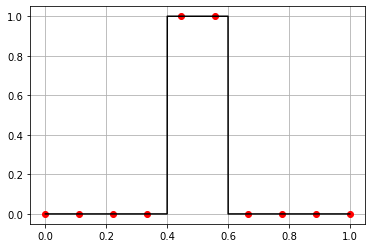

In [47]:
plt.plot(x_train,y_train,'ro')
plt.plot(x_test,y_test,'k-')
plt.grid()

In [48]:
class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel,self).__init__()
        self.linear1 = nn.Linear(1,32)
        self.linear2 = nn.Linear(32,32)
        self.linear3 = nn.Linear(32,1)
    def forward(self,x):
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = self.linear3(x)
        return x

In [49]:
device = torch.device('cuda')

In [50]:
model = BasicModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.05,weight_decay=1e-09)
scheduler = optim.lr_scheduler.StepLR(optimizer,100,gamma=0.9)

In [51]:
for epoch in range(5000):
    x_t = torch.FloatTensor(x_train).to(device)
    y_t = torch.FloatTensor(y_train).to(device)
    y_pred = model(x_t)
    loss = torch.mean((y_pred-y_t)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 1000 == 0:
        print(f'epoch: {epoch}, train loss: {loss.item()}')

epoch: 0, train loss: 0.462980717420578
epoch: 1000, train loss: 0.00017842835222836584
epoch: 2000, train loss: 2.415261224086862e-05
epoch: 3000, train loss: 1.858428367995657e-05
epoch: 4000, train loss: 1.731322663545143e-05


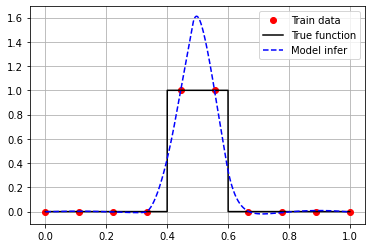

In [52]:
# test
x_plot = torch.FloatTensor(x_test).to(device)
y_plot = model(x_plot).detach().cpu().numpy()
plt.plot(x_train,y_train,'ro',label='Train data')
plt.plot(x_test,y_test,'k-',label='True function')
plt.plot(x_test,y_plot,'b--',label='Model infer')
plt.grid()
plt.legend()

In [54]:
# WENO interpolation - Box car
# Boundary condition: Periodic boundary condition
# Left stencil
# '''
#       |-----s2-----|
#    |------s1-----|
# |-----s0-----|
# ---|---|---|---|---
# i-2 i-1  i  i+1 i+2 
#          (i+1/2)
# '''
#Right stencil
# '''
# |-----s0-----|
#    |------s1-----|
#       |-----s2-----|
# ---|---|---|---|---
# i-2 i-1  i  i+1 i+2 
#     (i-1/2)
# '''
# WENO stencil: S[i] = [I(i-2)...I(i+2)]

In [56]:
# Lax-Friedrichs Flux Splitting
amp = max(y_train)
v = 0.5*(y_train+amp*y_train)
u = 0.5*(y_train-amp*y_train)

In [65]:
# Right flux
# Choose the positive Fluxes, 'v', to compute the left cell boundary flux
# u_i+1/2 ^ -
vmm = np.roll(y_train,2)
vm = np.roll(y_train,1)
vp = np.roll(y_train,-1)
vpp = np.roll(y_train,-2)

# Polynomial 
p0n = (2*vmm-7*vm+11*y_train)/6
p1n = (-vm+5*y_train+2*vp)/6
p2n = (2*y_train + 5*vp -vpp)/6

# smooth Indicators (Beta factors)
b0n = 13/12*(vmm-2*vm+y_train)**2+1/4*(vmm-4*vm+3*y_train)**2
b1n = 13/12*(vm-2*y_train+vp)**2+1/4*(vm-vp)**2
b2n = 13/12*(y_train-2*vp+vpp)**2+1/4*(3*y_train-4*vp+vpp)**2

# Constants
d0n, d1n, d2n, epsilon = 1/10, 6/10, 3/10, 1e-06

# Alpha weights
alpha0n = d0n/(epsilon+b0n)**2
alpha1n = d1n/(epsilon+b1n)**2
alpha2n = d2n/(epsilon+b2n)**2
alphasum = alpha0n+alpha1n+alpha2n

# ENO stencils weights
w0n = alpha0n/alphasum
w1n = alpha1n/alphasum
w2n = alpha2n/alphasum

#Numerical Flux at cell boundary, u^{-}_{i+1/2}
hn = w0n*p0n + w1n*p1n+ w2n*p2n

In [67]:
# Left flux
# Choose the negative Fluxes, 'v', to compute the left cell boundary flux
# u_i-1/2 ^ +
umm = np.roll(y_train,2)
um = np.roll(y_train,1)
up = np.roll(y_train,-1)
upp = np.roll(y_train,-2)

# Polynomials
p0p = (-umm+5*um+2*y_train)/6
p1p = (2*um+5*y_train-up)/6
p2p = (11*y_train-7*up+2*upp)/6

# Smooth indicator
b0p = 13/12*(umm-2*um+y_train)**2+1/4*(umm-4*um+3*y_train)**2
b1p = 13/12*(um-2*y_train+up)**2+1/4*(um-up)**2
b2p = 13/12*(y_train-2*up+upp)**2+1/4*(3*y_train-4*up+upp)**2

# Constants
d0p,d1p,d2p,epsilon = 3/10, 6/10, 1/10, 1e-06

# Alpha weights
alpha0p = d0p/(epsilon+b0p)**2
alpha1p = d1p/(epsilon+b1p)**2
alpha2p = d2p/(epsilon+b2p)**2
alphasum = alpha0p+alpha1p+alpha2p

# ENO stencils weights
w0p = alpha0p/alphasum
w1p = alpha1p/alphasum
w2p = alpha2p/alphasum

# Numerical Flux at cell bouncary, u_{i-1/2}^{+}
hp = w0p*p0p+w1p*p1p+w2p*p2p

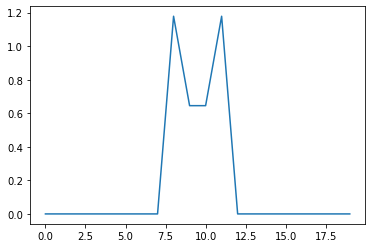

In [85]:
y_recon = np.zeros((len(y_train)*2,1))
y_recon[::2] = hn
y_recon[1::2] = hp
plt.plot(y_recon)

(10, 1)


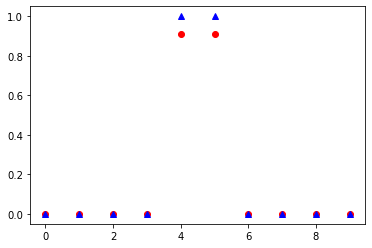

In [88]:
y_recon = (hp+hn)/2
print(y_recon.shape)
plt.plot(y_recon,'ro')
plt.plot(y_train,'b^')

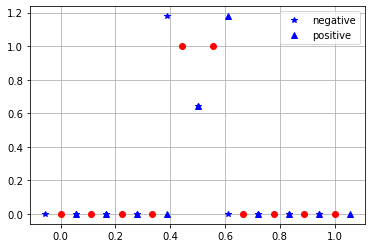

In [82]:
step = (x_train[1]-x_train[0])/2
x_ptrain = np.linspace(0+step,1+step,10).reshape(-1,1)
x_ntrain = np.linspace(0-step,1-step,10).reshape(-1,1)
plt.plot(x_train,y_train,'ro')
plt.plot(x_ntrain,hn,'b*',label='negative')
plt.plot(x_ptrain,hp,'b^',label='positive')
#plt.plot(x_train,(hn+hp)/2,'ko')
plt.grid()
plt.legend()

In [ ]:
plt.plot(x_train,y_train,'ro',label='Given data')
plt.plot(x_test,y_test,'k-',label='True function')
plt.plot(x_eno,y_eno,'b--',label='ENO interpolation')
plt.grid()
plt.label()